# Bitcoin price predictor using RNN

## Load data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(123)
import seaborn as sns
import datetime
from datetime import date
import yfinance as yf

In [2]:
########## DOWNLOAD DATA DIRECTLY FROM YAHOO FINANCE ##########
stocks = ['BTC-USD','^GSPC','DX-Y.NYB','^IXIC','GOOG','BTC=F','^KS11','000001.SS'] #### ADD FEATURES HERE ####
end = datetime.date.today()
start = datetime.datetime(2019,11,1)
stock_prices = yf.download(stocks,start=start,end = end, interval='1d')

[*********************100%***********************]  8 of 8 completed


In [3]:
raw_df = stock_prices
raw_df.head(5)

Adj Close                                               \
              000001.SS      BTC-USD   BTC=F   DX-Y.NYB         GOOG   
Date                                                                   
2019-11-01  2958.199951  9261.104492  9235.0  97.230003  1273.739990   
2019-11-02          NaN  9324.717773     NaN        NaN          NaN   
2019-11-03          NaN  9235.354492     NaN        NaN          NaN   
2019-11-04  2975.489990  9412.612305  9565.0  97.510002  1291.369995   
2019-11-05  2991.560059  9342.527344  9420.0  97.980003  1292.030029   

                                                         Close               \
                  ^GSPC        ^IXIC        ^KS11    000001.SS      BTC-USD   
Date                                                                          
2019-11-01  3066.909912  8386.400391  2100.199951  2958.199951  9261.104492   
2019-11-02          NaN          NaN          NaN          NaN  9324.717773   
2019-11-03          NaN          NaN          NaN          NaN  9235.354492   
2019-11-04  3078.270020  8433.200195  2130.239990  2975.489990  9412.612305   
2019-11-05  3074.620117  8434.679688  2142.639893  2991.560059  9342.527344   

            ...         Open                 Volume                       \
            ...        ^IXIC        ^KS11 000001.SS      BTC-USD   BTC=F   
Date        ...                                                            
2019-11-01  ...  8335.049805  2084.790039  159900.0  24324691031  2641.0   
2019-11-02  ...          NaN          NaN       NaN  21242676385     NaN   
2019-11-03  ...          NaN          NaN       NaN  21132220847     NaN   
2019-11-04  ...  8445.500000  2111.320068  167200.0  26170255634  3453.0   
2019-11-05  ...  8446.620117  2133.659912  179900.0  26198609047  2875.0   

                                                                      
           DX-Y.NYB       GOOG         ^GSPC         ^IXIC     ^KS11  
Date                                                                  
2019-11-01      0.0  1670100.0  3.930200e+09  2.057310e+09  418300.0  
2019-11-02      NaN        NaN           NaN           NaN       NaN  
2019-11-03      NaN        NaN           NaN           NaN       NaN  
2019-11-04      0.0  1501000.0  4.146850e+09  2.149910e+09  476300.0  
2019-11-05      0.0  1282700.0  4.486130e+09  2.316710e+09  400600.0  

[5 rows x 48 columns]

In [4]:
raw_df['Date'] =  raw_df.index

In [5]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

## Check features correlation with BITCOIN 

In [6]:
stock_prices['Close'].corr()

,000001.SS,BTC-USD,BTC=F,DX-Y.NYB,GOOG,^GSPC,^IXIC,^KS11
000001.SS,1.000000,0.719462,0.719330,-0.901404,0.802687,0.770758,0.889007,0.824519
BTC-USD,0.719462,1.000000,0.998666,-0.758327,0.877832,0.730924,0.849910,0.777889
BTC=F,0.719330,0.998666,1.000000,-0.757852,0.877129,0.733214,0.848698,0.777914
DX-Y.NYB,-0.901404,-0.758327,-0.757852,1.000000,-0.777180,-0.782485,-0.882620,-0.857360
GOOG,0.802687,0.877832,0.877129,-0.777180,1.000000,0.895609,0.927435,0.878716
^GSPC,0.770758,0.730924,0.733214,-0.782485,0.895609,1.000000,0.856393,0.963131
^IXIC,0.889007,0.849910,0.848698,-0.882620,0.927435,0.856393,1.000000,0.880036
^KS11,0.824519,0.777889,0.777914,-0.857360,0.878716,0.963131,0.880036,1.000000


<AxesSubplot:>

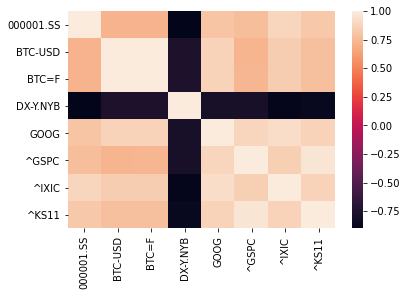

In [7]:
sns.heatmap(stock_prices['Close'].corr())

## Exploratory analysis

## formatting data - from yahoo finance

In [8]:
def get_data(indices,keys):
    a =[(key,index) for key in keys for index in indices]
    return raw_df[a] 

In [9]:
####### INCLUDE NEW FEATURES HERE ####### 
df = get_data(['BTC-USD','^GSPC','DX-Y.NYB','^IXIC','GOOG','BTC=F','^KS11','000001.SS'],['Close','High','Low','Volume'])  

In [10]:
df.head(3)

Close                                                   \
                BTC-USD        ^GSPC   DX-Y.NYB        ^IXIC        GOOG   
Date                                                                       
2019-11-01  9261.104492  3066.909912  97.230003  8386.400391  1273.73999   
2019-11-02  9324.717773          NaN        NaN          NaN         NaN   
2019-11-03  9235.354492          NaN        NaN          NaN         NaN   

                                                     High               ...  \
             BTC=F        ^KS11    000001.SS      BTC-USD        ^GSPC  ...   
Date                                                                    ...   
2019-11-01  9235.0  2100.199951  2958.199951  9275.657227  3066.949951  ...   
2019-11-02     NaN          NaN          NaN  9377.486328          NaN  ...   
2019-11-03     NaN          NaN          NaN  9379.806641          NaN  ...   

                    Low                    Volume                         \
                  ^KS11    000001.SS      BTC-USD         ^GSPC DX-Y.NYB   
Date                                                                       
2019-11-01  2081.530029  2917.149902  24324691031  3.930200e+09      0.0   
2019-11-02          NaN          NaN  21242676385           NaN      NaN   
2019-11-03          NaN          NaN  21132220847           NaN      NaN   

                                                                 
                   ^IXIC       GOOG   BTC=F     ^KS11 000001.SS  
Date                                                             
2019-11-01  2.057310e+09  1670100.0  2641.0  418300.0  159900.0  
2019-11-02           NaN        NaN     NaN       NaN       NaN  
2019-11-03           NaN        NaN     NaN       NaN       NaN  

[3 rows x 32 columns]

## Data preprossesing

### getting rid of NaNs

In [11]:
df = df.fillna(method='ffill')

### calculating percentage change of btc_price

In [12]:
df['percentage_change_price'] = df['Close']['BTC-USD'].pct_change()

In [13]:
df.head(2)

Close                                                   \
                BTC-USD        ^GSPC   DX-Y.NYB        ^IXIC        GOOG   
Date                                                                       
2019-11-01  9261.104492  3066.909912  97.230003  8386.400391  1273.73999   
2019-11-02  9324.717773  3066.909912  97.230003  8386.400391  1273.73999   

                                                     High               ...  \
             BTC=F        ^KS11    000001.SS      BTC-USD        ^GSPC  ...   
Date                                                                    ...   
2019-11-01  9235.0  2100.199951  2958.199951  9275.657227  3066.949951  ...   
2019-11-02  9235.0  2100.199951  2958.199951  9377.486328  3066.949951  ...   

                    Low       Volume                                       \
              000001.SS      BTC-USD         ^GSPC DX-Y.NYB         ^IXIC   
Date                                                                        
2019-11-01  2917.149902  24324691031  3.930200e+09      0.0  2.057310e+09   
2019-11-02  2917.149902  21242676385  3.930200e+09      0.0  2.057310e+09   

                                                  percentage_change_price  
                 GOOG   BTC=F     ^KS11 000001.SS                          
Date                                                                       
2019-11-01  1670100.0  2641.0  418300.0  159900.0                     NaN  
2019-11-02  1670100.0  2641.0  418300.0  159900.0                0.006869  

[2 rows x 33 columns]

In [14]:
####### CHECK UNBALANCED DATA SET ########
(df['percentage_change_price']>0).value_counts()

True     208
False    182
Name: percentage_change_price, dtype: int64

## Transform Date

In [15]:
df.columns

MultiIndex(levels=[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Date', 'percentage_change_price'], ['000001.SS', 'BTC-USD', 'BTC=F', 'DX-Y.NYB', 'GOOG', '^GSPC', '^IXIC', '^KS11', '']],
           codes=[[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 7], [1, 5, 3, 6, 4, 2, 7, 0, 1, 5, 3, 6, 4, 2, 7, 0, 1, 5, 3, 6, 4, 2, 7, 0, 1, 5, 3, 6, 4, 2, 7, 0, 8]])

In [16]:
new_colum_names = []
for el1, el2 in df.columns:
    new_colum_names.append(el1 + "_" + el2)
new_colum_names

['Close_BTC-USD',
 'Close_^GSPC',
 'Close_DX-Y.NYB',
 'Close_^IXIC',
 'Close_GOOG',
 'Close_BTC=F',
 'Close_^KS11',
 'Close_000001.SS',
 'High_BTC-USD',
 'High_^GSPC',
 'High_DX-Y.NYB',
 'High_^IXIC',
 'High_GOOG',
 'High_BTC=F',
 'High_^KS11',
 'High_000001.SS',
 'Low_BTC-USD',
 'Low_^GSPC',
 'Low_DX-Y.NYB',
 'Low_^IXIC',
 'Low_GOOG',
 'Low_BTC=F',
 'Low_^KS11',
 'Low_000001.SS',
 'Volume_BTC-USD',
 'Volume_^GSPC',
 'Volume_DX-Y.NYB',
 'Volume_^IXIC',
 'Volume_GOOG',
 'Volume_BTC=F',
 'Volume_^KS11',
 'Volume_000001.SS',
 'percentage_change_price_']

In [17]:
df.columns = new_colum_names

In [18]:
df['Date'] = df.index

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

df['year'] = df['Date'].dt.year

In [20]:
# Define percentage change in price column
df['delta_binary'] = df.percentage_change_price_>0
df['delta_binary'] = df['delta_binary'].astype(int)
df.head(2)

,Close_BTC-USD,Close_^GSPC,Close_DX-Y.NYB,Close_^IXIC,Close_GOOG,Close_BTC=F,Close_^KS11,Close_000001.SS,High_BTC-USD,High_^GSPC,...,Volume_^IXIC,Volume_GOOG,Volume_BTC=F,Volume_^KS11,Volume_000001.SS,percentage_change_price_,Date,month,year,delta_binary
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,9261.104492,3066.909912,97.230003,8386.400391,1273.73999,9235.0,2100.199951,2958.199951,9275.657227,3066.949951,...,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,NaN,2019-11-01,11,2019,0
2019-11-02,9324.717773,3066.909912,97.230003,8386.400391,1273.73999,9235.0,2100.199951,2958.199951,9377.486328,3066.949951,...,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,0.006869,2019-11-02,11,2019,1


In [21]:
df[['percentage_change_price_','delta_binary']].head(2)

,percentage_change_price_,delta_binary
Date,,
2019-11-01,NaN,0
2019-11-02,0.006869,1


In [22]:
scaled_names = df.columns[:-1]
scaled_names

Index(['Close_BTC-USD', 'Close_^GSPC', 'Close_DX-Y.NYB', 'Close_^IXIC',
       'Close_GOOG', 'Close_BTC=F', 'Close_^KS11', 'Close_000001.SS',
       'High_BTC-USD', 'High_^GSPC', 'High_DX-Y.NYB', 'High_^IXIC',
       'High_GOOG', 'High_BTC=F', 'High_^KS11', 'High_000001.SS',
       'Low_BTC-USD', 'Low_^GSPC', 'Low_DX-Y.NYB', 'Low_^IXIC', 'Low_GOOG',
       'Low_BTC=F', 'Low_^KS11', 'Low_000001.SS', 'Volume_BTC-USD',
       'Volume_^GSPC', 'Volume_DX-Y.NYB', 'Volume_^IXIC', 'Volume_GOOG',
       'Volume_BTC=F', 'Volume_^KS11', 'Volume_000001.SS',
       'percentage_change_price_', 'Date', 'month', 'year'],
      dtype='object')

## Data Sampling

- Out of this very long time-series, we will subsample it into shorter samples, each corresponding to one sequence of data  𝑋𝑖  with its corresponding prediction  𝑦𝑖 .
- get_sample -> function to get this random sample

Note:
  
  - **length** corresponds to the lenght of the observed sequence
  - **temporal_horizon** corresponds to the number of days between your last seen stock market value and the day you are trying to predict. -> in our case we want to predict for now the day after so tempor_horizon =1

In [23]:

def get_sample(df, length, temporal_horizon, random_start):
    features = [col_name for col_name in df.columns if col_name not in {'Date', 'Close_BTC-USD','delta_binary',
                                                                        'percentage_change_price_'} ]
    
    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    X_sample = df[features].iloc[random_start: random_start+length].values ## we need to say which features we are using??!
    y_sample = df['delta_binary'].iloc[random_start+length+temporal_horizon]
    y_before = df['delta_binary'].iloc[random_start+length+temporal_horizon-1]
   
    return X_sample, y_sample, y_before

get_sample(df,1,1)

For instance, get_sample(df, 10, 3) returns a first list of **10 stock market values**, and a second value which is the stock market value 3 days after the last seen value.

## Dataset construction

The previous function creates a sample (𝑋𝑖,𝑦𝑖) . If we repeat this operation, we will get multiple samples, that once concatenated will correspond to our entire dataset (𝑋,𝑦) .

Create a function get_X_y(data, temporal_horizon, length_of_sequences) that create this dataset.

- data corresponds to your input data
- temporal_horizon is the number of days between the last seen value and the predicted one
- length_of_sequences is a list that corresponds to the length of each sample 𝑋𝑖 : [len(X_1), len(X_2), len(X_3), ..., ] as that each sequence 𝑋𝑖 has no reason to be of the same length as the other one.

Hint: This function should use get_sample

In [24]:
# create a matrix
def get_X_y(df, temporal_horizon, length_of_sequences, start_of_sequences):
    X, y, y_before = [], [], []
    
    #import ipdb;ipdb.set_trace()

    for start in start_of_sequences:
        xi, yi, y_bi = get_sample(df, length_of_sequences, temporal_horizon, start)
        X.append(xi)
        y.append(yi)
        y_before.append(y_bi)
        
    return X, np.array(y), np.array(y_before)

 - Write a function given a dataframe, a temporal horizon and a list of sequence length outputs the padded train and test set.
 - To have a batch_size larger than one, we need to **pad** our data_ purely engineering reason
 

In [25]:
from sklearn.model_selection import train_test_split

def generate_data(df_train, df_test, temporal_horizon, length_of_sequences):
    
    np.random.seed(0)
    # Train 
    last_possible = df_train.shape[0] - temporal_horizon - length_of_sequences
    random_start = np.random.randint(0, last_possible)
    
    start_of_sequences_train = np.random.randint(0, last_possible, df_train.shape[0])
    
    X_train, y_train, y_b_train = get_X_y(df_train, temporal_horizon, length_of_sequences, start_of_sequences_train)
    X_train = pad_sequences(X_train, padding='post', dtype='float32')
   
    # Test
    last_possible = df_test.shape[0] - temporal_horizon - length_of_sequences
    random_start = np.random.randint(0, last_possible)
    
    start_of_sequences_test = np.random.randint(0, last_possible, df_test.shape[0])
    
    X_test, y_test, y_b_test = get_X_y(df_test, temporal_horizon, length_of_sequences, start_of_sequences_test)
    X_test = pad_sequences(X_test, padding='post', dtype='float32')
    
    return X_train, X_test, y_train, y_test, y_b_test, y_b_train

In [26]:
#generate_data(df_train, df_test, 1, 10)[0]

In [27]:
#old - generate_data(df_train, df_test, temporal_horizon, min_len, max_len)[0].shape

- Generate data with a temporal horizon of 1 days, and 100 time-series of 10 to 10 seen days .

## Split data

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Splitting 80/20
start = 1 # do a for loop
index = round((len(df)-start)*.8)

# Past
df_train = df.iloc[start:index+start]

#Future
df_test = df.iloc[start+index:]


temporal_horizon = 1 # -> predict the day after
#min_len = 7
#max_len = 8

length_of_sequences = 7

#(group 10 days,group of 20 days , # observations each time)


In [29]:
df_train.head()

,Close_BTC-USD,Close_^GSPC,Close_DX-Y.NYB,Close_^IXIC,Close_GOOG,Close_BTC=F,Close_^KS11,Close_000001.SS,High_BTC-USD,High_^GSPC,...,Volume_^IXIC,Volume_GOOG,Volume_BTC=F,Volume_^KS11,Volume_000001.SS,percentage_change_price_,Date,month,year,delta_binary
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-02,9324.717773,3066.909912,97.230003,8386.400391,1273.739990,9235.0,2100.199951,2958.199951,9377.486328,3066.949951,...,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,0.006869,2019-11-02,11,2019,1
2019-11-03,9235.354492,3066.909912,97.230003,8386.400391,1273.739990,9235.0,2100.199951,2958.199951,9379.806641,3066.949951,...,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,-0.009583,2019-11-03,11,2019,0
2019-11-04,9412.612305,3078.270020,97.510002,8433.200195,1291.369995,9565.0,2130.239990,2975.489990,9505.051758,3085.199951,...,2.149910e+09,1501000.0,3453.0,476300.0,167200.0,0.019193,2019-11-04,11,2019,1
2019-11-05,9342.527344,3074.620117,97.980003,8434.679688,1292.030029,9420.0,2142.639893,2991.560059,9457.417969,3083.949951,...,2.316710e+09,1282700.0,2875.0,400600.0,179900.0,-0.007446,2019-11-05,11,2019,0
2019-11-06,9360.879883,3076.780029,97.949997,8410.629883,1291.800049,9360.0,2144.149902,2978.600098,9423.237305,3078.340088,...,2.332650e+09,1152700.0,1366.0,410100.0,165300.0,0.001964,2019-11-06,11,2019,1


In [30]:
df_test = df_test.drop(columns = 'Date')
df = df.drop(columns = ['Date'])

In [31]:
df_train = df_train.drop(columns = 'Date')

In [33]:
df.head()

,Close_BTC-USD,Close_^GSPC,Close_DX-Y.NYB,Close_^IXIC,Close_GOOG,Close_BTC=F,Close_^KS11,Close_000001.SS,High_BTC-USD,High_^GSPC,...,Volume_DX-Y.NYB,Volume_^IXIC,Volume_GOOG,Volume_BTC=F,Volume_^KS11,Volume_000001.SS,percentage_change_price_,month,year,delta_binary
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01,9261.104492,3066.909912,97.230003,8386.400391,1273.739990,9235.0,2100.199951,2958.199951,9275.657227,3066.949951,...,0.0,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,NaN,11,2019,0
2019-11-02,9324.717773,3066.909912,97.230003,8386.400391,1273.739990,9235.0,2100.199951,2958.199951,9377.486328,3066.949951,...,0.0,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,0.006869,11,2019,1
2019-11-03,9235.354492,3066.909912,97.230003,8386.400391,1273.739990,9235.0,2100.199951,2958.199951,9379.806641,3066.949951,...,0.0,2.057310e+09,1670100.0,2641.0,418300.0,159900.0,-0.009583,11,2019,0
2019-11-04,9412.612305,3078.270020,97.510002,8433.200195,1291.369995,9565.0,2130.239990,2975.489990,9505.051758,3085.199951,...,0.0,2.149910e+09,1501000.0,3453.0,476300.0,167200.0,0.019193,11,2019,1
2019-11-05,9342.527344,3074.620117,97.980003,8434.679688,1292.030029,9420.0,2142.639893,2991.560059,9457.417969,3083.949951,...,0.0,2.316710e+09,1282700.0,2875.0,400600.0,179900.0,-0.007446,11,2019,0


df_test.dtypes

## Feature scaling

##### Fetaure scaling: only on train data ######

In [ ]:
# Scaling: MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#features_list = [col_name for col_name in df.columns if col_name not in {'Date', 'Close'} ]

# normalizing features
normalizer_features = MinMaxScaler()
normalizer_features.fit(df_train)
scaled_df = pd.DataFrame(normalizer_features.transform(df))

# mormalizing output/target
#normalizer_output = MinMaxScaler()
#normalizer_output.fit(df_train[['percentage_change_price']])
#scaled_df['percentage_change_price'] = normalizer_output.transform(df[['percentage_change_price']])
scaled_df['delta_binary'] = df.reset_index()[['delta_binary']]

# not normalizing, uncomment this
# scaled_df = df

## Generate data sequences

In [ ]:
scaled_df_train, scaled_df_test = scaled_df.iloc[start:(index+start)], scaled_df.iloc[start+index:]

In [ ]:
X_train, X_test, y_train, y_test, y_b_test, y_b_train = generate_data(scaled_df_train,
                                                    scaled_df_test, temporal_horizon, length_of_sequences)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_b_train.shape)
print(y_b_test.shape)

## Baseline model: LSTM with feature scaling 

- LSTM: Introduced to prevent the vanishing gradient: for **long** time-series, the gradient (of the backpropagation, during the optimizer updates) vanished to 0.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():

    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(7, activation='tanh'))
    model.add(layers.Dropout(0.1))
    #model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])# find loss an penalizing negative or positive results - alternatives to mae
                                  # mae weighted
    return model


In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
# Fit the model
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(patience=50, mode='min', verbose=1, monitor='val_loss',restore_best_weights=True)
# patience = 30 - > if my algorithm doesnt improve my performance for a certain number of iterations 
# (patience) stop the fitting process, return the weights as they are

history = model.fit(X_train,y_train,
          batch_size=310, 
          epochs=10000, # iteration through your data
          validation_split=0.2,
          callbacks=[es],
          verbose=1)

#history.history

In [ ]:

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Binary_crossentropy - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model loss')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [ ]:
y_pred = model.predict(X_test)
res = model.evaluate(X_test,y_test)
print(f'Loss on the test set : {res[0]:.8f}')
print(f'Accuracy on the test set : {res[1]:.8f}')

## TAs testing stuff

In [ ]:
bin_y_pred = y_pred >  0.5

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
y_test.shape

In [ ]:
res_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred.reshape(-1)})

In [ ]:
res_df.head()

In [ ]:
res_df['y_pred_bin'] = res_df['y_pred'] > 0.5

In [ ]:
res_df.head()

In [ ]:
res_df['correct'] = res_df['y_pred_bin'] == res_df['y_true'] 

In [ ]:
res_df.head()

In [ ]:
res_df['correct'].sum() / len(res_df)

In [ ]:
res_df.groupby('y_pred_bin')['y_pred_bin'].count().plot.bar()

In [ ]:
res_df.groupby('y_true')['y_true'].count().plot.bar()

In [ ]:
sum(correct ) /len(correct)

In [ ]:
X_test.shape

In [ ]:
X_test[0,:,:] == X_test[1,:,:]

In [ ]:
X_test[1,:,:]

## Backtesting the model 

In [ ]:
today_test_data = scaled_df.iloc[-7:,:-1].values.reshape(1,7,36)

In [ ]:
if model.predict(today_test_data)[0,0] > 0.5:
    print('time to buy')
else:
    print('time to sell')

In [ ]:
for day in range[7]:
    scaled_df.iloc[(-day-7):,:-1].values.reshape(1,day,36)
    
    